In [6]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import sqlite3
import re
import numpy as np
import tabulate
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [7]:
print("Fetching main faculty page...")
data = requests.get('https://www.iiserkol.ac.in/web/en/people/faculty/dbs/')
soup = BeautifulSoup(data.content, "html.parser")

# Collecting faculty profile URLs
urls = [link['href'] for link in soup.find_all('a')]
urls = [url for url in urls if '/web/en/people/faculty/dbs/' in url]
link = 'https://www.iiserkol.ac.in'
faculty_websites = list(set([link + url for url in urls]))
print(f"Found {len(faculty_websites)} faculty profile URLs.")

Fetching main faculty page...
Found 27 faculty profile URLs.


In [53]:
all_data = []
print("Scraping individual faculty pages...")

for faculty_url in faculty_websites:
    try:
        data = requests.get(faculty_url)
        data.raise_for_status()
        soup = BeautifulSoup(data.content, "html.parser")

        # Get faculty name
        name = soup.find_all('h3')
        faculty_name = [name.text for name in name]
        faculty_name = faculty_name[3].strip() if len(faculty_name) > 3 else None

        if not faculty_name:
            print(f"Skipping URL (could not find name): {faculty_url}")
            continue

        print(f"Processing: {faculty_name}")

        # Initialize profile dictionary
        profile_data = {
            "Name": faculty_name,
            "Positions": None,
            "Designation": None,
            "Academic Background": None,
            "PhD": None,
            "PhD Year": None,
            "Years of Experience": None,
            "Research Interest": None,
            "Awards and Honors": None,
            "Number of awards": 0,
        }

        # Get main profile content
        content = soup.find_all('div', class_='col-md-12 innerdiv')

        for section in content:
            section_text = section.get_text(separator="\n", strip=True)

            if 'Positions:' in section_text:
                profile_data["Positions"] = re.sub(r'Positions:\s+', '', section_text)
                positions_text = re.sub(r'Positions:\s+', '', section_text)
                profile_data["Positions"] = positions_text

                # 2. Now, try to find the specific "current" position
                current_position_found = False
                lines = positions_text.split('\n') # Split by newlines

                for line in lines:
                    if '(current)' in line.lower(): # Check for '(current)'
                        profile_data["Designation"] = line.strip()
                        current_position_found = True
                        break # Found it, stop looking

                # 3. Fallback: If no '(current)' found, assume the first non-empty line is current
                if not current_position_found and lines:
                    for first_line in lines:
                        first_line = first_line.strip()
                        if first_line: # Make sure it's not just an empty line
                            profile_data["Designation"] = first_line
                            break # Got the first one, stop


            elif 'Academic Background:' in section_text:
                profile_data["Academic Background"] = re.sub(r'Academic Background:\s+', '', section_text)

                # Try to extract PhD info from this section
                c = re.search(r"\d{4}", section_text) # Look for a 4-digit year
                if c:
                    x = c.start()
                    profile_data["PhD Year"] = section_text[x:x+4]
                    if 'PhD' in section_text or 'phd' in section_text or 'Ph.D' in section_text:
                        phd_text = section_text[21:x-1].strip(" ,")
                        profile_data["PhD"] = phd_text



            elif 'Research Interest:' in section_text:
                profile_data["Research Interest"] = re.sub(r'Research Interest:\s+', '', section_text)


            elif 'Awards and Honors:' in section_text:
                profile_data["Awards and Honors"] = re.sub(r'Awards and Honors:\s+', '', section_text)
                try:
                    award_count = (section_text.count('20') + section_text.count('19') -
                                   section_text.count('2020') - section_text.count('2019'))
                    # This will overwrite the default 0 if awards are found
                    profile_data["Number of awards"] = award_count
                except Exception:

                    profile_data["Number of awards"] = 0

        if profile_data["PhD Year"]:
            try:
                current_year = 2025 # Based on your system's date
                phd_year_int = int(profile_data["PhD Year"])

                # Basic validation
                if 1900 < phd_year_int <= current_year:
                    experience = current_year - phd_year_int
                    profile_data["Years of Experience"] = experience

            except (ValueError, TypeError):
                # This handles cases where PhD Year is None or not a valid number
                profile_data["Years of Experience"] = None


        all_data.append(profile_data)

    except requests.exceptions.RequestException as e:
        print(f"Error fetching URL {faculty_url}: {e}")
        continue

print("Scraping complete.")

Scraping individual faculty pages...
Processing: Tapas Kumar Sengupta
Processing: Arnab Gupta
Processing: Supratim Datta
Processing: Jayasri Das Sarma
Processing: Sumit Sen Santara
Processing: Anindita Bhadra
Processing: Partha Pratim Datta
Processing: Radhika Venkatesan
Processing: Punyasloke Bhadury
Processing: Rahul Das
Processing: Dipjyoti Das
Processing: Rituparna Sinha Roy
Processing: Neelanjana Sengupta
Processing: Annagiri Sumana
Processing: Robert John Chandran
Processing: Babu Sudhamalla
Processing: Bidisha Sinha
Processing: Sreeramaiah Gangappa
Processing: Rupak Datta
Processing: Amit Kumar Mandal
Processing: Partho Sarothi Ray
Processing: Amirul Islam Mallick
Processing: Malancha Ta
Processing: Mohit Prasad
Processing: Sankar Maiti
Processing: Anuradha Bhat
Processing: Sunil Kumar Khare
Scraping complete.


In [54]:
print("Connecting to database and saving data...")
conn = sqlite3.connect("faculty_data.db")
cursor = conn.cursor()

# Drop the table if it already exists
cursor.execute("DROP TABLE IF EXISTS Faculty")

# Create the new table
cursor.execute('''
CREATE TABLE Faculty (
    Name TEXT,
    Positions TEXT,
    Designation TEXT,
    Academic_Background TEXT,
    PhD TEXT,
    PhD_Year INTEGER,
    Years_of_Experience INTEGER,
    Research_Interest TEXT,
    Awards_and_Honors TEXT,
    Number_of_awards INTEGER
)
''')

# Insert data into the table
for profile in all_data:
    cursor.execute('''
    INSERT INTO Faculty (
        Name, Positions, Designation, Academic_Background, PhD, PhD_Year, Years_of_Experience, Research_Interest,
        Awards_and_Honors, Number_of_awards
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', (
        profile["Name"],
        profile["Positions"],
        profile["Designation"],
        profile["Academic Background"],
        profile["PhD"],
        profile["PhD Year"],
        profile["Years of Experience"],
        profile["Research Interest"],
        profile["Awards and Honors"],
        profile["Number of awards"]
    ))

# Commit changes
conn.commit()
print("Data saved to faculty_data.db")

Connecting to database and saving data...
Data saved to faculty_data.db


In [55]:
print("Loading data into pandas DataFrame...")
# Read data from SQL back into a pandas DataFrame
df = pd.read_sql_query("SELECT * FROM Faculty", conn)

# Close the database connection
# conn.close() # Removed this line to keep the connection open

# Define list of Indian locations
Indian_cities = [
    "Adilabad", "Adoni", "Agartala", "Agra", "Ahmedabad", "Ahmednagar", "Aizawl", "Ajmer", "Akola",
"Aligarh", "Allahabad", "Alwar", "Amravati", "Ambattur", "Amritsar", "Anand", "Anantapur",
"Andaman and Nicobar Islands", "Andhra Pradesh", "Arrah", "Arunachal Pradesh", "Asansol",
"Aurangabad", "Aurangabad (Bihar)", "Avadi", "Bally", "Balasore", "Bareilly", "Baramati",
"Baramulla", "Barasat", "Bardhaman", "Baripada", "Barmer", "Bathinda", "Begusarai", "Belgaum",
"Bellary", "Bengaluru", "Berhampur", "Bhagalpur", "Bhavnagar", "Bhilai", "Bhilwara", "Bhiwani",
"Bhopal", "Bhubaneswar", "Bhuj", "Bihar", "Bihar Sharif", "Bijapur", "Bilaspur", "Bilaspur (HP)",
"BITS Goa", "BITS Hyderabad", "BITS Pilani", "Bokaro", "Bombay", "Brahmapur", "Burdwan",
"Calcutta", "Chandigarh", "Chandrapur", "Chapra", "Chennai", "Chhattisgarh", "Chittoor", "Coimbatore",
"Cuddalore", "Cuttack", "Darbhanga", "Darjeeling", "Davanagere", "Dadra and Nagar Haveli and Daman and Diu",
"Dehradun", "Deoghar", "Delhi", "Dewas", "Dhanbad", "Dharwad", "Dhule", "Dibrugarh", "Dindigul",
"Diu", "Dumka", "Durg", "Durgapur", "Eluru", "Erode", "Faridabad", "Farrukhabad", "Firozabad",
"Gandhinagar", "Gaya", "Ghaziabad", "Giridih", "Goa", "Gopalganj", "Gorakhpur", "Gujarat",
"Gulbarga", "Guntur", "Guwahati", "Gwalior", "Hamirpur", "Haldia", "Haldwani", "Hapur", "Haridwar",
"Haryana", "Hazaribagh", "Himachal Pradesh", "Hindupur", "Hoshangabad", "Howrah", "Hubli-Dharwad",
"Hosur", "Hyderabad", "Ichalkaranji", "IIIT Allahabad", "IIIT Hyderabad", "IISc", "IISER Berhampur",
"IISER Bhopal", "IISER Kolkata", "IISER Mohali", "IISER Pune", "IISER Tirupati", "Imphal",
"Indore", "India", "Indian", "Jabalpur", "Jagdalpur", "Jadavpur", "Jaipur", "Jaisalmer", "Jalgaon",
"Jalna", "Jalpaiguri", "Jammu and Kashmir", "Jamnagar", "Jamui", "Jamshedpur", "Jhansi", "Jharkhand",
"Jhunjhunu", "JNU", "Jodhpur", "Junagadh", "Kadapa", "Kakinada", "Kalyan-Dombivli", "Kalyani",
"Kanchipuram", "Kanpur", "Kanyakumari", "Karaikal", "Karimnagar", "Karur", "Karnal", "Karnataka",
"Kathua", "Khammam", "Kharagpur", "Kochi", "Kolhapur", "Kolkata", "Kollam", "Korba", "Kota",
"Kothagudem", "Kozhikode", "Kulti", "Kumbakonam", "Kurnool", "Ladakh", "Lakshadweep", "Latur",
"Loni", "Lovely Professional University", "Lucknow", "Ludhiana", "Machilipatnam", "Madurai", "Madras",
"Mahbubnagar", "Maheshtala", "Malda", "Malegaon", "Mangalore", "Manipal", "Manipur", "Mandi",
"Mathura", "Mau", "Meerut", "Meghalaya", "Moradabad", "Morena", "Mumbai", "Muzaffarnagar",
"Muzaffarpur", "Mysuru", "Nagaland", "Nagpur", "Nainital", "Nanded", "Nashik", "Navi Mumbai",
"Nellore", "New Delhi", "NIT Calicut", "NIT Surathkal", "NIT Trichy", "NIT Warangal", "Nizamabad",
"Noida", "Odisha", "Ongole", "Ozhukarai", "Palakkad", "Panihati", "Panipat", "Parbhani", "Patiala",
"Patna", "Puducherry", "Pune", "Purnia", "Punjab", "Rajasthan", "Raiganj", "Raipur", "Rajahmundry",
"Rajkot", "Ranchi", "Rampur", "Ratlam", "Ratnagiri", "Rewa", "Rishikesh", "Ropar", "Roorkee",
"Rourkela", "Sagar", "Salem", "Samastipur", "Sambalpur", "Sangli", "Satara", "Satna", "Saharanpur",
"Shahjahanpur", "Shimla", "Shillong", "Shimoga", "Sikar", "Silchar", "Siliguri", "Siwan", "Solan",
"Solapur", "Sonipat", "South Dumdum", "Srikakulam", "Srinagar", "SRM Chennai", "Surat", "Tamil Nadu",
"Tanjavur", "Telangana", "Thanjavur", "Thiruvananthapuram", "Thrissur", "Tiruchirappalli", "Tirunelveli",
"Tirupati", "Tiruppur", "Tripura", "Tumkur", "Udaipur", "Ujjain", "Ulhasnagar", "Una", "Uttar Pradesh",
"Uttarakhand", "Vadodara", "Varanasi", "Vasai-Virar", "Vellore", "Vijayawada", "Visakhapatnam",
"Vizianagaram", "VIT Vellore", "Warangal", "Wardha", "West Bengal"

]

# Function to classify PhD institution
def institution(phd_string):
    if phd_string is None:
        return None
    for institute in Indian_cities:
        if institute in str(phd_string):
            return "India"
    return "Abroad"

# Apply the function to create a new column
df['PhD_Institution'] = df['PhD'].apply(institution)

# Create filtered DataFrames for further analysis
df_filtered = df[df['PhD_Institution'].notna()]
df_yrAw = df.dropna(subset=["Number_of_awards", "PhD_Year"])

# Prepare data for potential plotting or curve fitting
years = df_yrAw["PhD_Year"]
Aws = df_yrAw["Number_of_awards"]

print("Analysis complete. DataFrame 'df' is ready.")



Loading data into pandas DataFrame...
Analysis complete. DataFrame 'df' is ready.


In [56]:
print("\nPhD Institution Counts:")

# Just this on the last line, with NO print()
df['PhD_Institution'].value_counts()


PhD Institution Counts:


,count
PhD_Institution,
India,21
Abroad,6


In [57]:
from IPython.display import display

# --- 1. Define the columns you want to show
tableheadings = [
    'Name',
    'Positions',
    'Designation',
    'Academic_Background',
    'PhD',
    'PhD_Year',
    'Years_of_Experience',
    'PhD_Institution',
    'Research_Interest',
    'Awards_and_Honors',
    'Number_of_awards'
]
dfnew = df[tableheadings]

# --- 2. Define your styles as a list of CSS rules ---
styles = [
    # --- Style for the whole table: borders ---
    {'selector': 'table',
     'props': [('border-collapse', 'collapse'),
               ('border', '2px solid black')]},

    # --- Style for all cells (th=header, td=data): borders and padding ---
    {'selector': 'th, td',
     'props': [('border', '1px solid #999'),
               ('padding', '8px'),
               ('text-align', 'left')]},

    # --- Style for just the header row: background color and font ---
    {'selector': 'th',
     'props': [('background-color', '#f2f2f2'),
               ('color', 'black'),
               ('font-weight', 'bold')]}
]

# --- 3. Apply the styles and create the styled object ---
styleddf = (dfnew.style
    # Apply all the border and header styles defined above
    .set_table_styles(styles)

    # --- Set column widths ---
    # Set a default width for all long columns
    .set_properties(**{'min-width': '200px', 'max-width': '300px'})

    # Set a specific width for short columns
    .set_properties(subset=['PhD_Year', 'Number_of_awards', 'PhD_Institution'], **{'min-width': '100px', 'max-width': '100px'})

    # --- Add color to a column ---
    # Applies a color gradient (heatmap) to the 'Number_of_awards' column
    .background_gradient(subset=['Years_of_Experience'], cmap='Blues')

    # --- Set row height (optional) ---
    .set_properties(**{'height': '50px'})
)

# --- 4. Display the final, styled table ---
display(styleddf)

,Name,Positions,Designation,Academic_Background,PhD,PhD_Year,Years_of_Experience,PhD_Institution,Research_Interest,Awards_and_Honors,Number_of_awards
0,Tapas Kumar Sengupta,"Professor, IISER Kolkata ( - ) Associate Professor, Indian Institute of Science Education and Research Kolkata (2010 - 2018) Assistant Professor, Indian Institute of Science Education and Research Kolkata (2007 - 2010)","Professor, IISER Kolkata ( - )","PhD (Biochemistry), Bose Institute (Calcutta University), 1996","PhD (Biochemistry), Bose Institute (Calcutta University)",1996,29,India,"i) Understanding cancer biology at the level of regulation of gene expression and cancer therapeutics.ii) Microbiological, molecular and ecological characterization of intra- and interspecific interactions in natural isolates of microorganisms and application of such interactions for bioremedial purposes.",None,0
1,Arnab Gupta,"Associate Professor, IISER Kolkata (current) Assistant Professor, IISER Kolkata (2017 - 2021) Ramanujan Fellow, University of Calcutta (2015 - 2017)","Associate Professor, IISER Kolkata (current)","PhD (Human Genetics), CSIR-Indian Inst of Chemical Biology (Jadavpur University), 2007 MSc (Zoology (H)), University of Calcutta, 2000","PhD (Human Genetics), CSIR-Indian Inst of Chemical Biology (Jadavpur University)",2007,18,India,"Cell biology, membrane trafficking, eukaryotic copper metabolism.",None,0
2,Supratim Datta,"Professor, IISER Kolkata (current) Associate Professor, Indian Institute of Science Education and Research Kolkata (2017 - 2021) Assistant Professor, Indian Institute of Science Education and Research Kolkata (2011 - 2016) Energy Bioscience Overseas Fellow, Indian Institute of Science Education and Research Kolkata (2011 - 2016) Postdoctoral Scientist, Sandia National Lab., Livermore, USA and Lawrence Berkeley Lab., Berkeley, USA (2008 - 2011) Research Fellow, University of Michigan, Ann Arbor (2004 - 2008)","Professor, IISER Kolkata (current)","Ph.D. (Chemistry), Boston University, Boston, 2005","Ph.D. (Chemistry), Boston University, Boston",2005,20,Abroad,The research in my laboratory focuses on engineering proteins and organisms to yield improved and novel functions for industrial and pharmaceutical applications. We plan on combining synthetic biology-based approach with protein and metabolic engineering techniques with an overall goal of providing biology-based solutions in areas of bioenergy and chemical production.,Ramanujan Fellowship from Government of India (2011) Energy Bioscience Overseas Fellowship from Government of India (2011),2
3,Jayasri Das Sarma,"Professor, IISER Kolkata ( - ) Adjunct Associate Professor, Department of Ophthalmology, University of Pennsylvania, Philadelphia, USA (2013 - 2018) Adjunct Faculty, Pathology, Anatomy and Cell Biology (2012 - 2015) Adjunct Faculty, Department of Neurology, Thomas Jefferson University, Philadelphia, USA (2008 - 2012) Assistant Professor, Department of Neurology, Thomas Jefferson University, Philadelphia, USA (2004 - 2008) Senior Research Investigator, Department of Microbiology, University of Pennsylvania, Philadelphia, USA. (2003 - 2003) Research Associate, Institute for Environmental Medicine and Department of Physiology, University of Pennsylvania, USA (2001 - 2002) Post Doctoral Researcher, Institute for Environmental Sciences and Department of Physiology, University of Pennsylvania, USA. (1999 - 2000) Post Doctoral Fellow, Department of Pathology and Laboratory Medicine, University of Pennsylvania, Philadelphia, USA (1997 - 1998) Research Associate, Rockefeller Foundation Program, MRDG, Indian Institute of Science, Bangalore, India (1995 - 1996)","Professor, IISER Kolkata ( - )","PhD (Immunology/Biochemistry), Indian Statistical Institute (Jadavpur), 1995, In collaboration with Indian Institute of Chemical Biology","PhD (Immunology/Biochemistry), Indian Statistical Institute (Jadavpur)",1995,30,India,"My laboratory is involved in the study of neuropathogenesis of murine


PhD Institution Counts:
PhD_Institution
India     21
Abroad     6
Name: count, dtype: int64

Generating pie chart...
Pie chart saved as 'phd_institution_pie_chart.png'
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

Classifying Designation...

Position Classification Counts:
Position_Class
Professor              16
Associate Professor     8
Assistant Professor     3
Name: count, dtype: int64

Generating position distribution pie chart...
Pie chart saved as 'position_distribution_pie_chart.png'
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

Analyzing PhD Origin for 'Professor' rank only...

'Professor' PhD Institution Counts:
PhD_Institution
India     12
Abroad     4
Name: count, dtype: int64

Generating 'Professor' PhD origin pie chart...
Pie cha

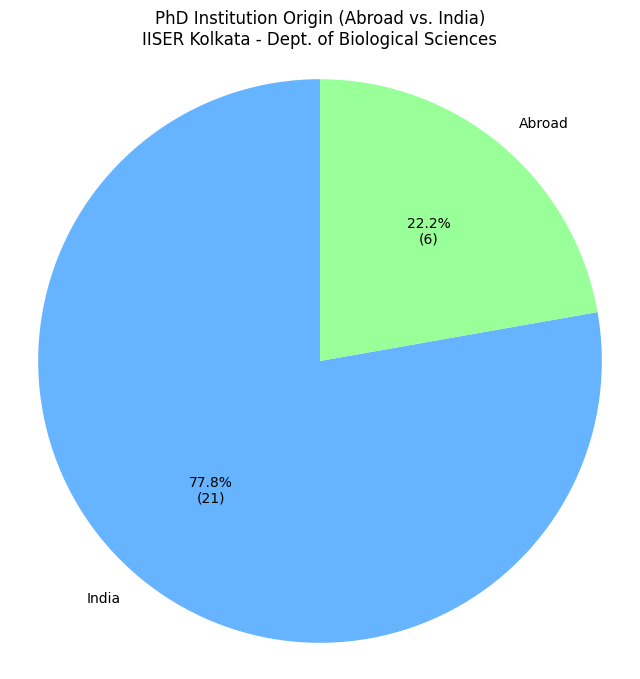

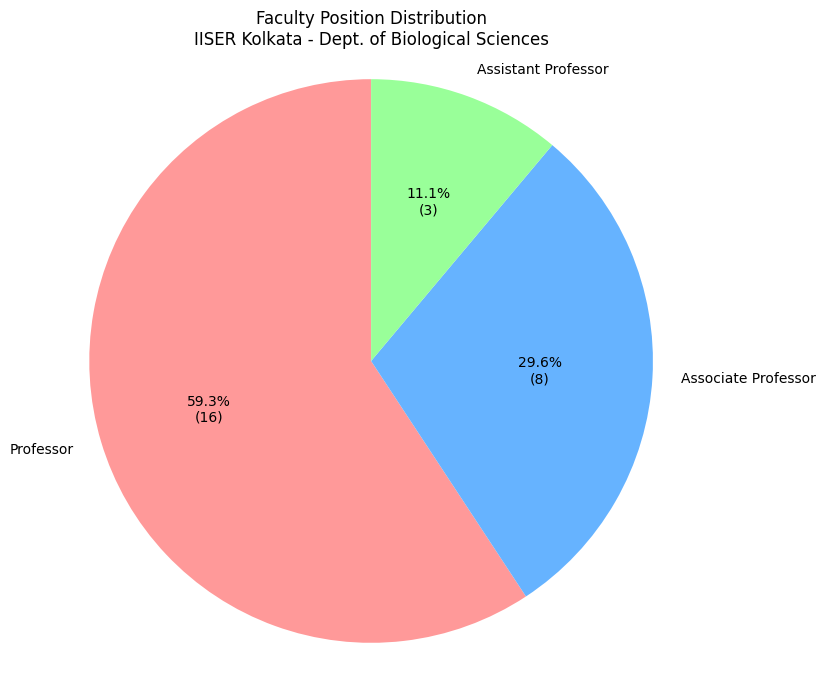

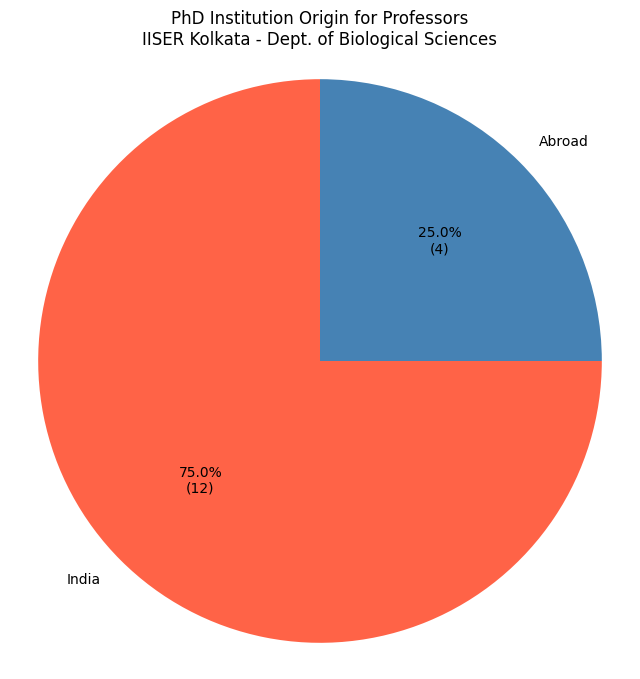

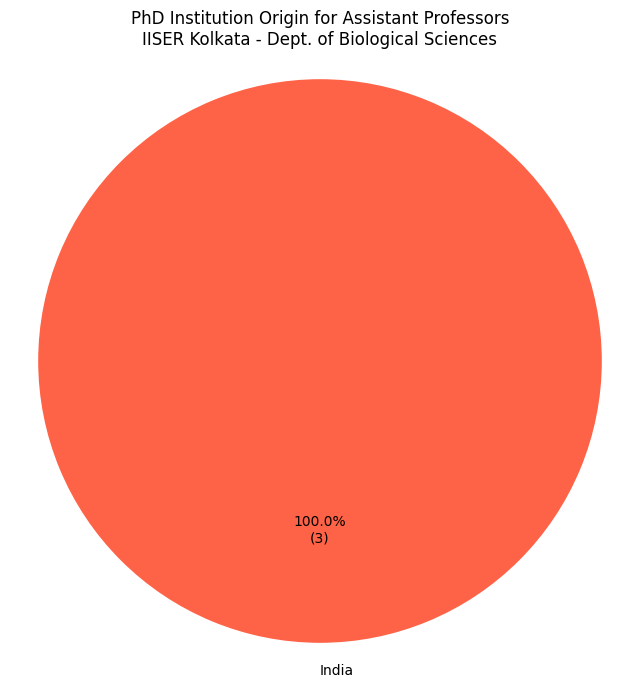

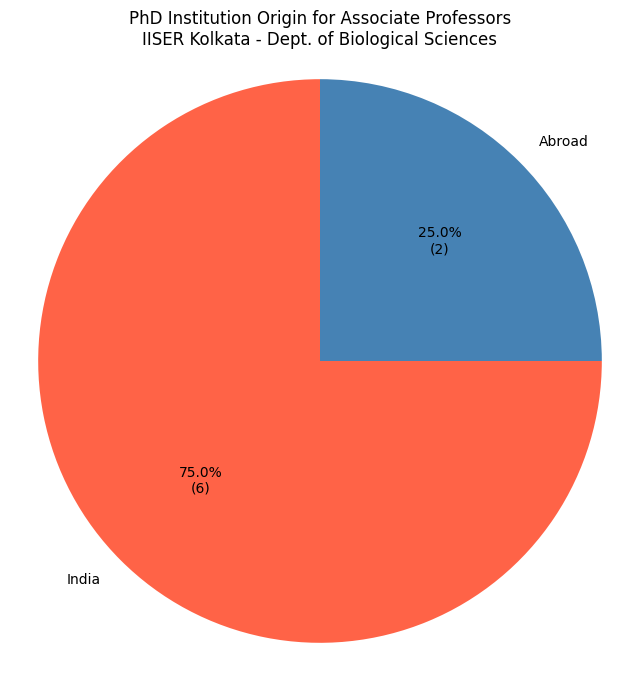

In [58]:
# PhD classification India vs Abroad

print("\nPhD Institution Counts:")
    # Get the counts, store them in a variable, and print them
phd_counts = df['PhD_Institution'].value_counts()
print(phd_counts)


# PhD classification India vs Abroad - PIE CHART

print("\nGenerating pie chart...")

    # Get data and labels from the value counts
labels = phd_counts.index
sizes = phd_counts.values

    # Create the plot
plt.figure(figsize=(8, 8)) # Set a good size
colors = ['#66b3ff','#99ff99'] # Add some custom colors

    # Plot the pie chart with percentages
plt.pie(sizes, labels=labels, autopct=lambda pct: f'{pct:1.1f}%\n({int(round(pct/100.*sum(sizes)))})', startangle=90, colors=colors)

    # Add a title
plt.title('PhD Institution Origin (Abroad vs. India)\nIISER Kolkata - Dept. of Biological Sciences')

    # Ensure the pie chart is a circle
plt.axis('equal')

    # Save the plot to a file
plt.savefig("phd_institution_pie_chart.png")
print("Pie chart saved as 'phd_institution_pie_chart.png'")

print('-----------------------------------------------------------------------------------------------------------------------------------------------------------------------')

# Position classisfication Professors vs Assistant Professors vs Associate Professors

print("\nClassifying Designation...")

def classify_position(position_str):
    """
    Classifies a faculty position based on keywords.
    Checks for Associate/Assistant first to avoid misclassifying as 'Professor'.
    """
    if position_str is None:
        return 'Other'

    pos_lower = position_str.lower()

    if 'associate professor' in pos_lower:
        return 'Associate Professor'
    elif 'assistant professor' in pos_lower:
        return 'Assistant Professor'
    elif 'professor' in pos_lower:
        return 'Professor'
    else:
        return 'Other'

# Apply the classification function to the 'Designation' column
df['Position_Class'] = df['Designation'].apply(classify_position)

# Get and print the counts for the new classification
position_counts = df['Position_Class'].value_counts()
print("\nPosition Classification Counts:")
print(position_counts)


# Position classisfication Professors vs Assistant Professors vs Associate Professors - PIE CHART
print("\nGenerating position distribution pie chart...")

# Get data and labels from the position counts
pos_labels = position_counts.index
pos_sizes = position_counts.values

# Create the plot
plt.figure(figsize=(8, 8)) # Set a good size
# Define colors for the positions (you can change these)
pos_colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

# Plot the pie chart with both percentage and absolute number
plt.pie(pos_sizes, labels=pos_labels,
        autopct=lambda pct: f'{pct:1.1f}%\n({int(round(pct/100.*sum(pos_sizes)))})',
        startangle=90, colors=pos_colors)

plt.title('Faculty Position Distribution\nIISER Kolkata - Dept. of Biological Sciences')
plt.axis('equal')  # Ensure the pie chart is a circle

# Save the plot to a new file
plt.savefig("position_distribution_pie_chart.png")
print("Pie chart saved as 'position_distribution_pie_chart.png'")

print('-----------------------------------------------------------------------------------------------------------------------------------------------------------------------')

# PhD origin: Professors India vs Abroad

print("\nAnalyzing PhD Origin for 'Professor' rank only...")

# Filter the DataFrame for only 'Professor'
prof_df = df[df['Position_Class'] == 'Professor']

# Get and print the PhD institution counts *for this subset*
prof_phd_counts = prof_df['PhD_Institution'].value_counts()
print("\n'Professor' PhD Institution Counts:")
print(prof_phd_counts)

# PhD origin: Professors India vs Abroad - PIE CHART
print("\nGenerating 'Professor' PhD origin pie chart...")

# Get data and labels
prof_phd_labels = prof_phd_counts.index
prof_phd_sizes = prof_phd_counts.values

# Create the plot
plt.figure(figsize=(8, 8)) # Set a good size
prof_phd_colors = ['#ff6347','#4682b4'] # Tomato and SteelBlue

# Plot the pie chart with both percentage and absolute number
plt.pie(prof_phd_sizes, labels=prof_phd_labels,
        autopct=lambda pct: f'{pct:1.1f}%\n({int(round(pct/100.*sum(prof_phd_sizes)))})',
        startangle=90, colors=prof_phd_colors)

plt.title('PhD Institution Origin for Professors\nIISER Kolkata - Dept. of Biological Sciences')
plt.axis('equal')  # Ensure the pie chart is a circle

# Save the plot to a new file
plt.savefig("professor_phd_origin_pie_chart.png")
print("Pie chart saved as 'professor_phd_origin_pie_chart.png'")

print('-----------------------------------------------------------------------------------------------------------------------------------------------------------------------')

# PhD origin: Assistant Professors India vs Abroad

print("\nAnalyzing PhD Origin for 'Assistant Professor' rank only...")

# Filter the DataFrame for only 'Assistant Professor'
astprof_df = df[df['Position_Class'] == 'Assistant Professor']

# Get and print the PhD institution counts *for this subset*
astprof_phd_counts = astprof_df['PhD_Institution'].value_counts()
print("\n'Assistant Professor' PhD Institution Counts:")
print(astprof_phd_counts)

# PhD origin: Assistant Professors India vs Abroad - PIE CHART
print("\nGenerating 'Assistant Professor' PhD origin pie chart...")

# Get data and labels
astprof_phd_labels = astprof_phd_counts.index
astprof_phd_sizes = astprof_phd_counts.values

# Create the plot
plt.figure(figsize=(8, 8)) # Set a good size
astprof_phd_colors = ['#ff6347','#4682b4'] # Tomato and SteelBlue

# Plot the pie chart with both percentage and absolute number
plt.pie(astprof_phd_sizes, labels=astprof_phd_labels,
        autopct=lambda pct: f'{pct:1.1f}%\n({int(round(pct/100.*sum(astprof_phd_sizes)))})',
        startangle=90, colors=astprof_phd_colors)

plt.title('PhD Institution Origin for Assistant Professors\nIISER Kolkata - Dept. of Biological Sciences')
plt.axis('equal')  # Ensure the pie chart is a circle

# Save the plot to a new file
plt.savefig("assistantprofessor_phd_origin_pie_chart.png")
print("Pie chart saved as 'assistantprofessor_phd_origin_pie_chart.png'")

print('-----------------------------------------------------------------------------------------------------------------------------------------------------------------------')

# PhD origin: Associate Professors India vs Abroad

print("\nAnalyzing PhD Origin for 'Associate Professor' rank only...")

# Filter the DataFrame for only 'Associate Professor'
ascprof_df = df[df['Position_Class'] == 'Associate Professor']

# Get and print the PhD institution counts *for this subset*
ascprof_phd_counts = ascprof_df['PhD_Institution'].value_counts()
print("\n'Associate Professor' PhD Institution Counts:")
print(ascprof_phd_counts)

# PhD origin: Associate Professors India vs Abroad - PIE CHART
print("\nGenerating 'Associate Professor' PhD origin pie chart...")

# Get data and labels
ascprof_phd_labels = ascprof_phd_counts.index
ascprof_phd_sizes = ascprof_phd_counts.values

# Create the plot
plt.figure(figsize=(8, 8)) # Set a good size
ascprof_phd_colors = ['#ff6347','#4682b4'] # Tomato and SteelBlue

# Plot the pie chart with both percentage and absolute number
plt.pie(ascprof_phd_sizes, labels=ascprof_phd_labels,
        autopct=lambda pct: f'{pct:1.1f}%\n({int(round(pct/100.*sum(ascprof_phd_sizes)))})',
        startangle=90, colors=ascprof_phd_colors)

plt.title('PhD Institution Origin for Associate Professors\nIISER Kolkata - Dept. of Biological Sciences')
plt.axis('equal')  # Ensure the pie chart is a circle

# Save the plot to a new file
plt.savefig("associateprofessor_phd_origin_pie_chart.png")
print("Pie chart saved as 'associateprofessor_phd_origin_pie_chart.png'")

print('-----------------------------------------------------------------------------------------------------------------------------------------------------------------------')


Generating 'Awards by Designation' bar graph...
Bar graph saved as 'awards_by_designation_bar.png'
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

Generating 'Experience by Designation' bar graph...
Bar graph saved as 'experience_by_designation_bar.png'
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

Generating 'Awards by PhD Location' bar graph...
Bar graph saved as 'awards_by_phd_location_bar.png'
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------


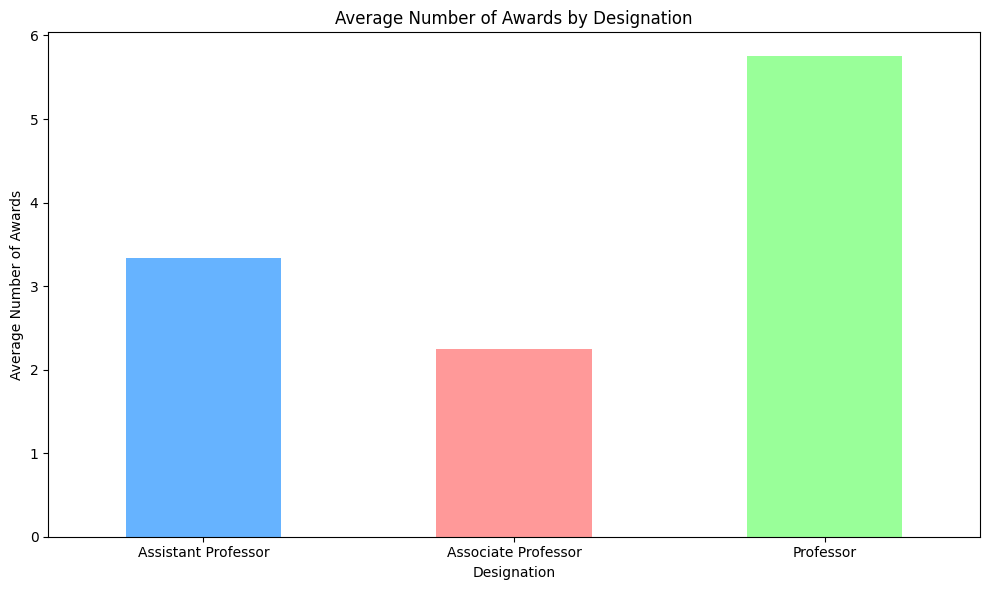

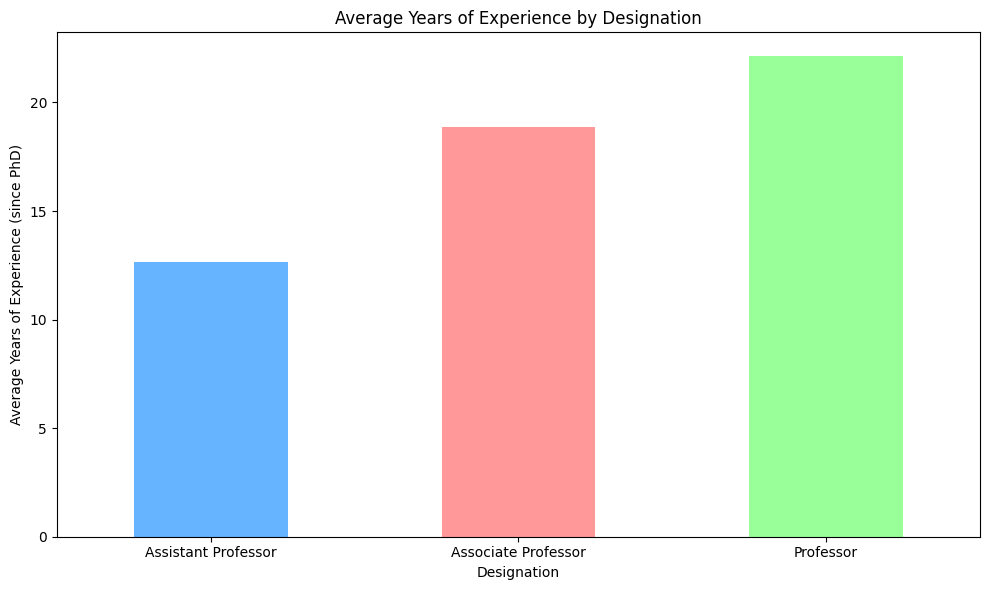

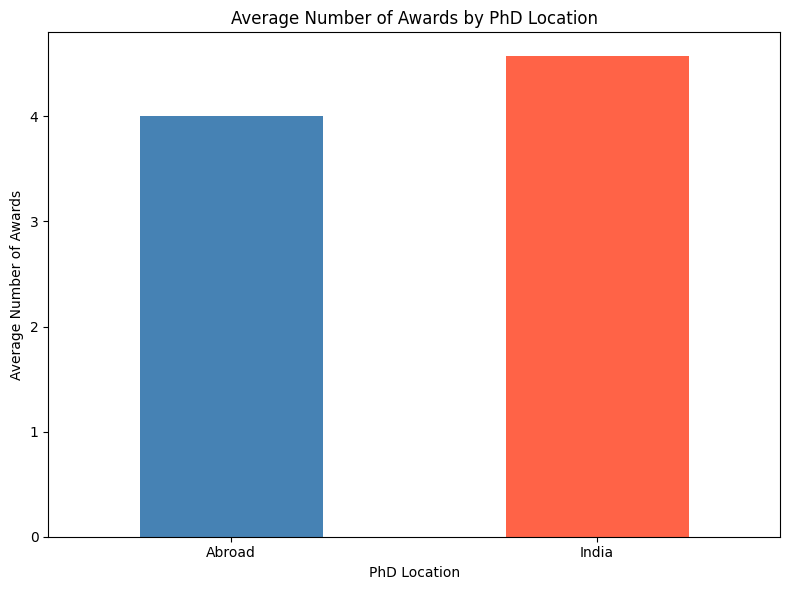

In [59]:
# --- Graph 1: Average Awards by Designation ---
print("\nGenerating 'Awards by Designation' bar graph...")
# Group by position and calculate the mean, filtering out 'Other'
awards_by_pos = df[df['Position_Class'] != 'Other'].groupby('Position_Class')['Number_of_awards'].mean()
# Re-order for logical presentation
awards_by_pos = awards_by_pos.reindex(['Assistant Professor', 'Associate Professor', 'Professor'])

plt.figure(figsize=(10, 6))
awards_by_pos.plot(kind='bar', color=['#66b3ff', '#ff9999', '#99ff99'])
plt.title('Average Number of Awards by Designation')
plt.xlabel('Designation')
plt.ylabel('Average Number of Awards')
plt.xticks(rotation=0) # Keep labels horizontal
plt.tight_layout()
plt.savefig("awards_by_designation_bar.png")
print("Bar graph saved as 'awards_by_designation_bar.png'")

print('-----------------------------------------------------------------------------------------------------------------------------------------------------------------------')

# --- Graph 2: Average Experience by Designation ---
print("\nGenerating 'Experience by Designation' bar graph...")
# Group by position and calculate the mean, filtering out 'Other'
exp_by_pos = df[df['Position_Class'] != 'Other'].groupby('Position_Class')['Years_of_Experience'].mean()
# Re-order for logical presentation
exp_by_pos = exp_by_pos.reindex(['Assistant Professor', 'Associate Professor', 'Professor'])

plt.figure(figsize=(10, 6))
exp_by_pos.plot(kind='bar', color=['#66b3ff', '#ff9999', '#99ff99'])
plt.title('Average Years of Experience by Designation')
plt.xlabel('Designation')
plt.ylabel('Average Years of Experience (since PhD)')
plt.xticks(rotation=0) # Keep labels horizontal
plt.tight_layout()
plt.savefig("experience_by_designation_bar.png")
print("Bar graph saved as 'experience_by_designation_bar.png'")

print('-----------------------------------------------------------------------------------------------------------------------------------------------------------------------')

# --- Graph 3: Average Awards by PhD Location ---
print("\nGenerating 'Awards by PhD Location' bar graph...")
# Group by PhD location and calculate the mean
awards_by_phd_loc = df.groupby('PhD_Institution')['Number_of_awards'].mean()

plt.figure(figsize=(8, 6))
awards_by_phd_loc.plot(kind='bar', color=['#4682b4', '#ff6347'])
plt.title('Average Number of Awards by PhD Location')
plt.xlabel('PhD Location')
plt.ylabel('Average Number of Awards')
plt.xticks(rotation=0) # Keep labels horizontal
plt.tight_layout()
plt.savefig("awards_by_phd_location_bar.png")
print("Bar graph saved as 'awards_by_phd_location_bar.png'")

print('-----------------------------------------------------------------------------------------------------------------------------------------------------------------------')


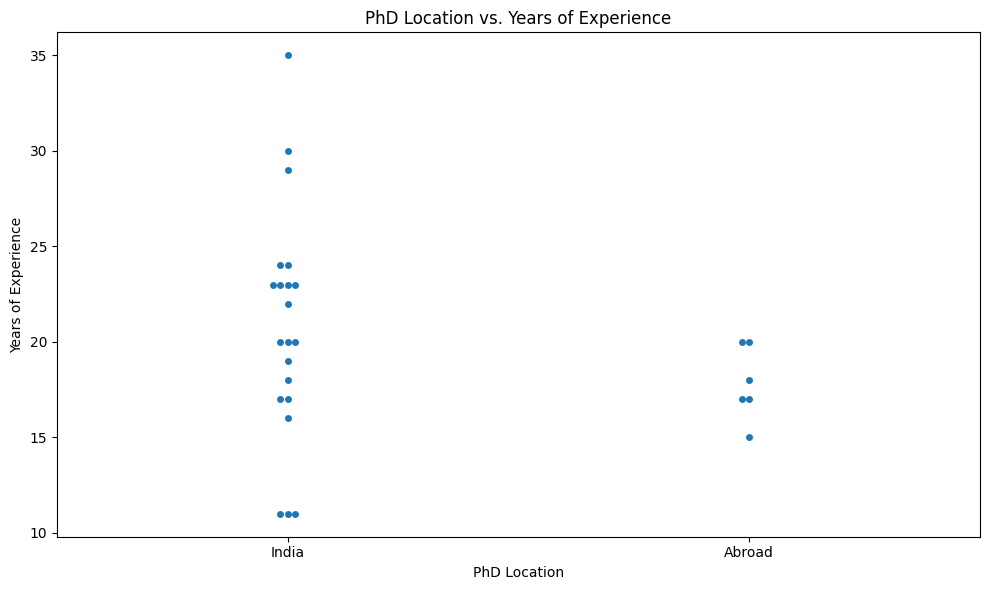

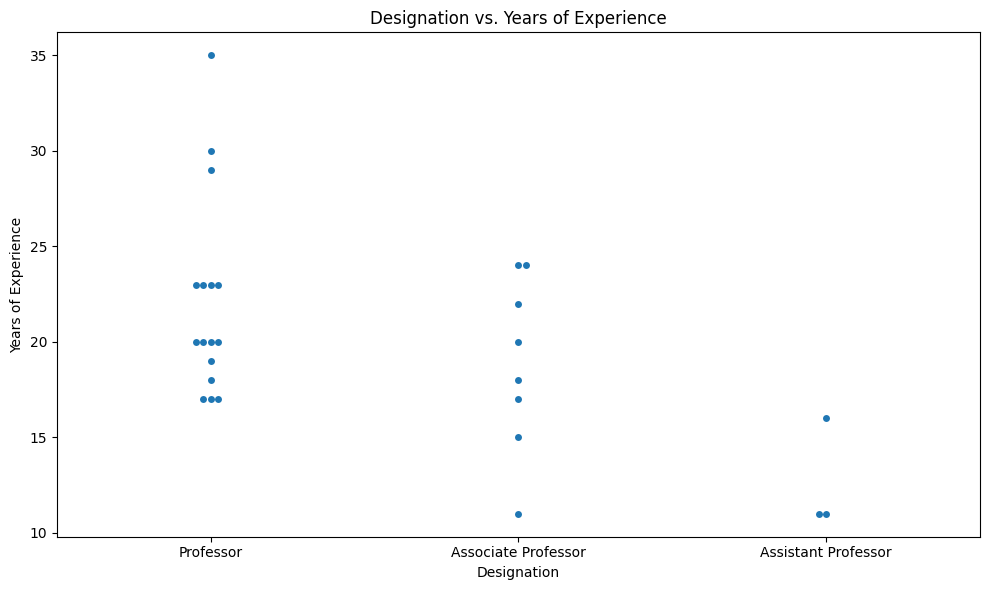

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'Years_of_Experience' and 'Position_Class' columns are available
# Calculate Years of Experience
current_year = 2025 # Based on your system's date
df['Years_of_Experience'] = df['PhD_Year'].apply(lambda phd_year: current_year - int(phd_year) if pd.notna(phd_year) else None)

# Classify positions
def classify_position(position_str):
    """
    Classifies a faculty position based on keywords.
    Checks for Associate/Assistant first to avoid misclassifying as 'Professor'.
    """
    if position_str is None:
        return 'Other'

    pos_lower = position_str.lower()

    if 'associate professor' in pos_lower:
        return 'Associate Professor'
    elif 'assistant professor' in pos_lower:
        return 'Assistant Professor'
    elif 'professor' in pos_lower:
        return 'Professor'
    else:
        return 'Other'

# Apply the classification function to the 'Designation' column
df['Position_Class'] = df['Designation'].apply(classify_position)


#Ph.D. Location vs. Years of Experience (Swarm Plot)
plt.figure(figsize=(10, 6))
sns.swarmplot(x='PhD_Institution', y='Years_of_Experience', data=df)
plt.title('PhD Location vs. Years of Experience')
plt.xlabel('PhD Location')
plt.ylabel('Years of Experience')
plt.tight_layout()
plt.show()


#Designation vs. Years of Experience
plt.figure(figsize=(10, 6))
sns.swarmplot(x='Position_Class', y='Years_of_Experience', data=df)
plt.title('Designation vs. Years of Experience')
plt.xlabel('Designation')
plt.ylabel('Years of Experience')
plt.tight_layout()
plt.show()


# Ph.D. Location vs. Designation (size = Years_of_Experience) - Removed due to incompatibility with swarmplot size parameter


Generating 'Experience vs. Awards' scatter plot...
Scatter plot saved as 'experience_vs_awards_scatter.png'


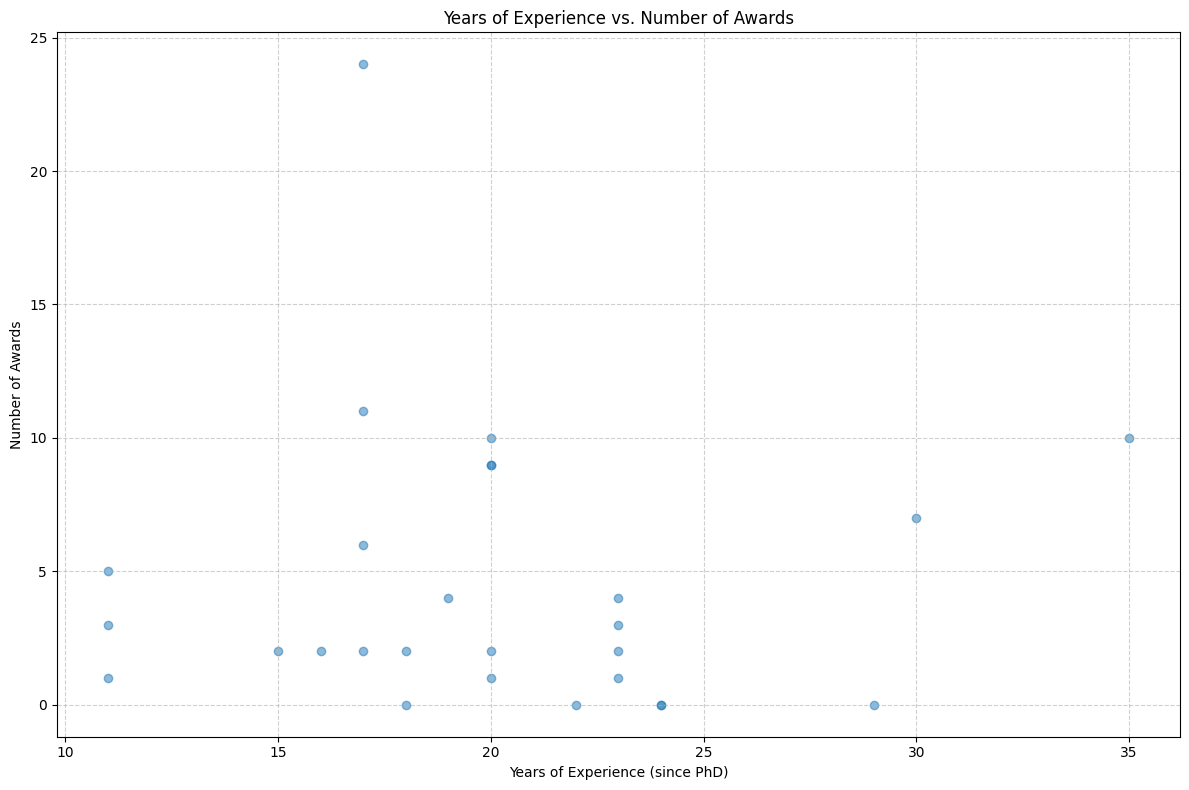

In [62]:
print("\nGenerating 'Experience vs. Awards' scatter plot...")

# Drop rows where either value is missing for a clean plot
scatter_data = df.dropna(subset=['Years_of_Experience', 'Number_of_awards'])

plt.figure(figsize=(12, 8))
plt.scatter(scatter_data['Years_of_Experience'], scatter_data['Number_of_awards'], alpha=0.5)
plt.title('Years of Experience vs. Number of Awards')
plt.xlabel('Years of Experience (since PhD)')
plt.ylabel('Number of Awards')
plt.grid(True, linestyle='--', alpha=0.6) # Add a grid for readability
plt.tight_layout()
plt.savefig("experience_vs_awards_scatter.png")
print("Scatter plot saved as 'experience_vs_awards_scatter.png'")